# 1. Setup

In [ ]:
# source material: https://www.youtube.com/watch?v=VMj-3S1tku0

# imports
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 2. Understanding what a gradient means and visualizing the chain rule.

- define a scaler valued function
- draw its curve
- manually calculate its derivative
- define a more complex function
- manually calculate its derivative
- draw a graph of the complex function
- manually populate the gradients/derivative
- visualize the gradient chaining i.e. back-propagation


In [ ]:
# scaler valued function
# it takes a single scaler: x
# and returns a single scaler: y
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
print(f(3.0))

20.0


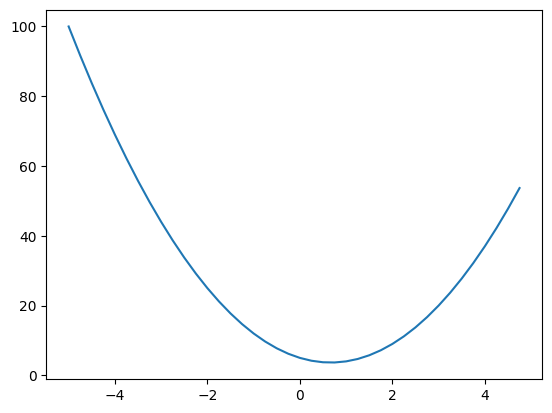

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [ ]:
# understanding gradient at a point
h = 0.00000001
x = 3.0
print(f(x+h))
print(f"derivative is: {(f(x+h) -f(x))/h}")

20.00000014
derivative is: 14.00000009255109


In [ ]:
# with a bit more complex example
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
print('d1', d1)
h = 0.0001
a += h
d2 = a*b + c
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [ ]:
class Value:
  def __init__(self, data, ):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data)
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data)
    return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
e = a*b
d = e+c
print("value of d: ", d)
#(a.__mul__(b)).__add__(c)
f = Value(-2.0)
L = d*f
print(L)

value of d:  Value(data=4.0)
Value(data=-8.0)


Need to add additional information to Value class to plot a graph of the expressions and visualize the chain rule.
- children of each Value node, if any
- operand that creates a Value node, if any
- label of each Value node
- gradient at each Value node

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op=(), label=''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), "tanh")
    return out

a = Value(2.0, label='a')
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label = "e"
d = e+c; d.label = "d"
print("value of d: ", d)
#(a.__mul__(b)).__add__(c)
print("children of d: ", d._prev)
print("operation that created d: ", d._op)
f = Value(-2.0, label="f")
L = d*f; L.lable = "L"
print(L)

value of d:  Value(data=4.0)
children of d:  {Value(data=-6.0), Value(data=10.0)}
operation that created d:  +
Value(data=-8.0)


In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

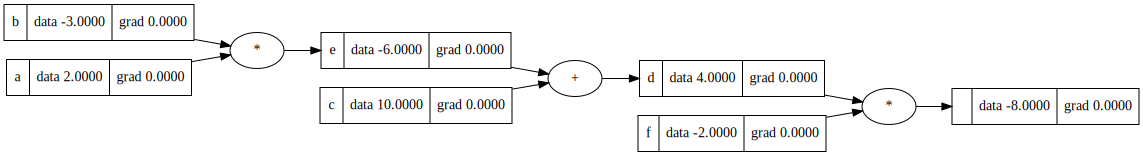

In [ ]:
draw_dot(L)

L = d * f

dL/dd = ? f



In [ ]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [ ]:
# function to mathematically check the gradients
def lol():

  h = 0.0001
  a = Value(2.0, label='a')
  b = Value(-3.0, label="b")
  c = Value(10.0, label="c")
  e = a*b; e.label = "e"
  d = e+c; d.label = "d"
  f = Value(-2.0, label="f")
  L = d*f; L.lable = "L"
  L1 = L.data

  a = Value(2.0 + h, label='a')
  b = Value(-3.0, label="b")
  c = Value(10.0, label="c")
  e = a*b; e.label = "e"
  d = e+c; d.label = "d"
  f = Value(-2.0, label="f")
  L = d*f; L.lable = "L"
  L2 = L.data

  print((L2-L1)/h)

lol()

6.000000000021544


# 3. Building A neuron using the value class




#### 3.1 Which parts of neuron are missing from the value class?

Neurons or neural networks (as implemented in ML/AI) are just abstractions of mathematical equations/expressions. So we can build a neural network using functionality that we have implemented so far.

![Neuron](https://cs231n.github.io/assets/nn1/neuron_model.jpeg "A neuron")

A neuron consists of:
- inputs (x0 --> xn)
- weights (w0 --> wn)
- bias (b)
- linear expression of inputs, weights & bias (written in cell body in above image)
- activation function (f, I'm using tanh in the example below)



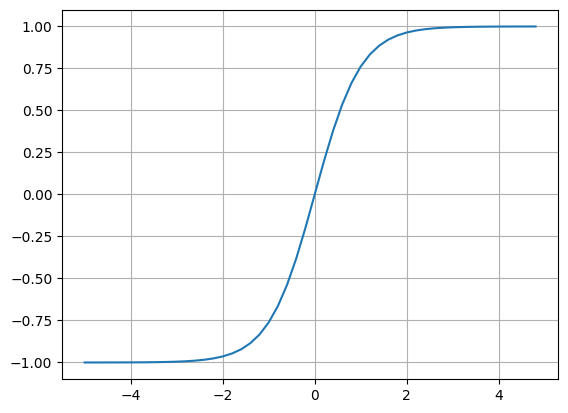

In [ ]:
# visualizing tanh function
plt.grid(True)
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))


Writing backpropagation logic within the Value class and manually calling it to perform back-propagation.



In [ ]:
class Value:
  def __init__(self, data, _children=(), _op=(), label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), "tanh")
    def _backward():
      self.grad = (1 - out.data**2) * out.grad
    out._backward = _backward
    return out

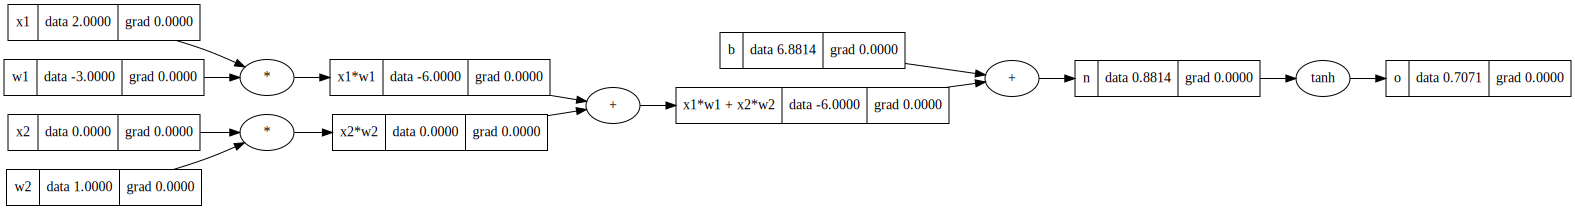

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

Manually calling the backpropagating logic

In [ ]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2
# do/dn = 1 - o**2
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

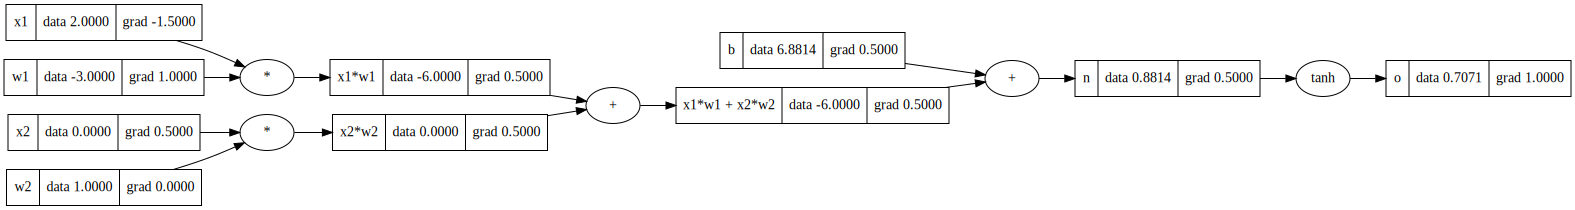

In [ ]:
draw_dot(o)

#### 3.2 Moving towards automatic back-propogation

- In order to automatically back-propagate, we need to know the correct order in which back-propagation should be done, i.e. everything that a node depends, should already have its gradient calculated beforehand.
- topological sort/graph provides this ordering


In [ ]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo
# topo list contains the requisite ordering to automate the back-propagation

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op=(), label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), "tanh")
    def _backward():
      self.grad = (1 - out.data**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    # building a topological graph
    # of all the nodes in the expression which forms the Value self
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    # setting the self gradient to be 1
    self.grad = 1.0
    # back-propogating the gradients to each node in the expression
    # that forms self, in the topological ordering
    for node in topo[::-1]:
      node._backward()

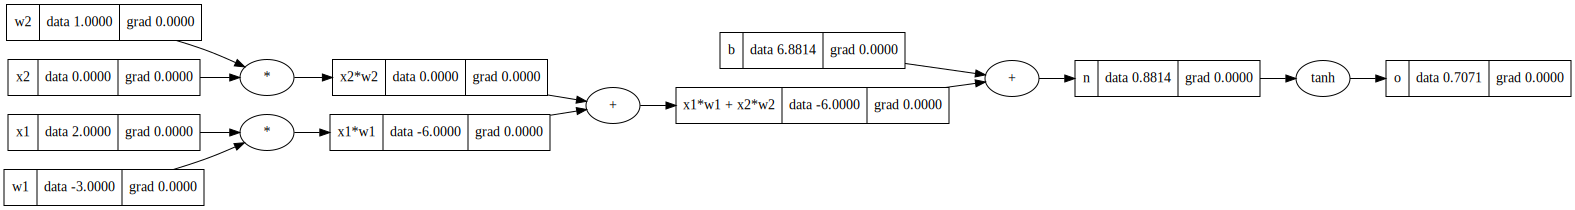

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

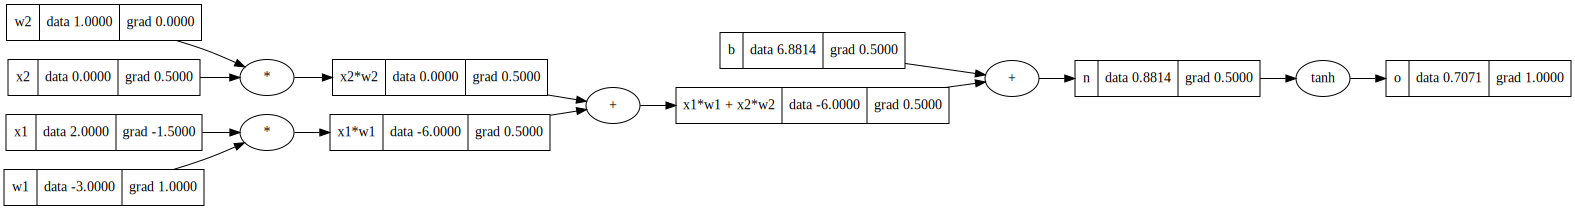

In [ ]:
o.backward()
draw_dot(o)

#### 3.3 BUG!!!

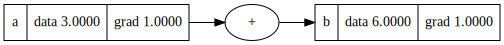

In [ ]:
a = Value(3.0, label="a")
b = a + a
b.label = "b"
b.backward()
draw_dot(b)

Forward pass works. See that b.data = 6

But the back-propogation has failed. a.grad = 1

b = a + a

db/da = da/da + da/da

db/da = 1 + 1

db/da = 2

Ideally there should be two a nodes each pointing to +, in the graph above.

But currently there is a single a node with two arrows pointing to + (both are on top of each other, that's why not visible in the graph above).

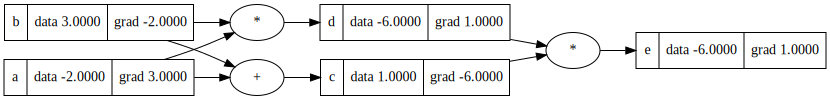

In [ ]:
# another example to illustrate this
a = Value(-2.0, label="a")
b = Value( 3.0, label="b")
c = a + b
c.label = "c"
d = a * b
d.label = "d"
e = c * d
e.label = "e"

e.backward()
draw_dot(e)

Whenever a node/variable is being used more than once. Its gradients are getting over-ridden.


In order to handle this, multi-variate case of chain-rule needs to be applied. Which states that instead of setting the gradients in each step/update, gradients should be accumulated in each step/update.

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op=(), label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), "tanh")
    def _backward():
      self.grad += (1 - out.data**2) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    # building a topological graph
    # of all the nodes in the expression which forms the Value self
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    # setting the self gradient to be 1
    self.grad = 1.0
    # back-propogating the gradients to each node in the expression
    # that forms self, in the topological ordering
    for node in topo[::-1]:
      node._backward()

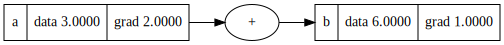

In [ ]:
a = Value(3.0, label="a")
b = a + a
b.label = "b"
b.backward()
draw_dot(b)

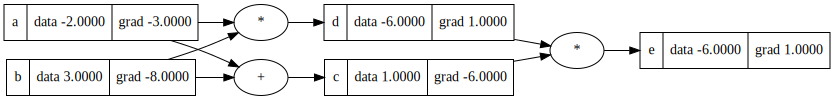

In [ ]:
# another example to illustrate this
a = Value(-2.0, label="a")
b = Value( 3.0, label="b")
c = a + b
c.label = "c"
d = a * b
d.label = "d"
e = c * d
e.label = "e"

e.backward()
draw_dot(e)

#### 3.4 Handling scaler constant addition to the Value objects, subtraction, negation, exponent, pow.

In [ ]:
class Value:
  def __init__(self, data, _children=(), _op=(), label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __radd__(self, other):
    return self + other

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * (other ** -1)

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supports int/float powers"
    out = Value(self.data**other, (self, ), f"**{other}")
    def _backward():
      self.grad += other * self.data**(other-1) * out.grad
      self._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), "tanh")
    def _backward():
      self.grad += (1 - out.data**2) * out.grad
    out._backward = _backward
    return out

  def expn(self):
    x = self.data
    out = Value(math.exp(x), (self, ), "expn")
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):
    # building a topological graph
    # of all the nodes in the expression which forms the Value self
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        #print(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    # setting the self gradient to be 1
    self.grad = 1.0
    # back-propogating the gradients to each node in the expression
    # that forms self, in the topological ordering
    for node in topo[::-1]:
      node._backward()

In [ ]:
a = Value(2)
b = Value(1)
c = a-b
c.backward()


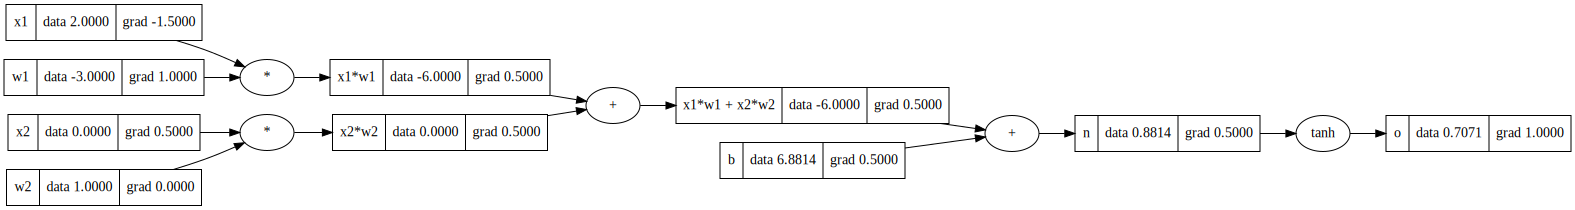

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

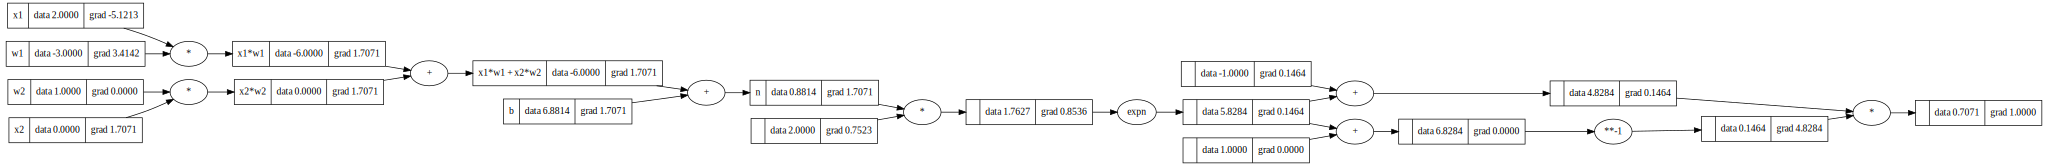

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#----
e = (2*n).expn()
o = (e-1) / (e+1)
#----
o.backward()
draw_dot(o)

# 4. Enter PyTorch!!

In [ ]:
import torch

#### 4.1 Using PyTorch for everything done manually above

Everything we did before building the neuron

In [ ]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


Building the Neuron

In [ ]:
import random
class Neuron:

  def __init__(self, n_in):
    self.w = [Value(random.uniform(-1,1)) for _ in range(n_in)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # this is the function that gets executed when you run n(x) below
    # n = Neuron(2)
    # n(x)
    # essentially we want to do w * x + b here
    # which is the forward pass
    act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
    out = act.tanh()
    return out

x = [2.0, 3.0]
n = Neuron(2)
n(x)


Value(data=0.9952814410099012)

Building a layer of neurons

In [ ]:
class Layer:

  def __init__(self, n_in, n_out):
    self.neurons = [ Neuron(n_in) for _ in range(n_out)]

  def __call__(self, X):
    out = [n(X) for n in self.neurons]
    return out if len(out) > 1 else out[0]

x = [2.0, 3.0]
n = Layer(2, 3)
n(x)


[Value(data=-0.9878405782588525),
 Value(data=0.9985227923792788),
 Value(data=0.05880992556732832)]

Building an MLP

![MLP](https://cs231n.github.io/assets/nn1/neural_net2.jpeg "MLP")

In [ ]:
class MLP:

  def __init__(self, n_in, n_outs):
    sz = [n_in] + n_outs
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outs))]

  def __call__(self, X):
    for layer in self.layers:
      X = layer(X)
    return X

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.9568556413717273)

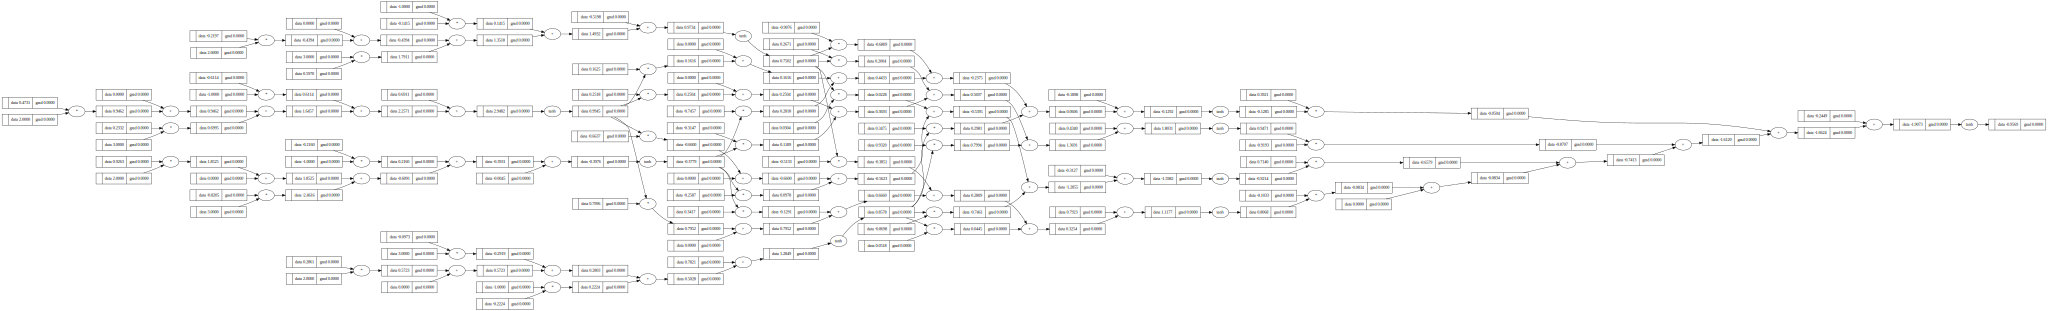

In [ ]:
N = n(x)
draw_dot(N)

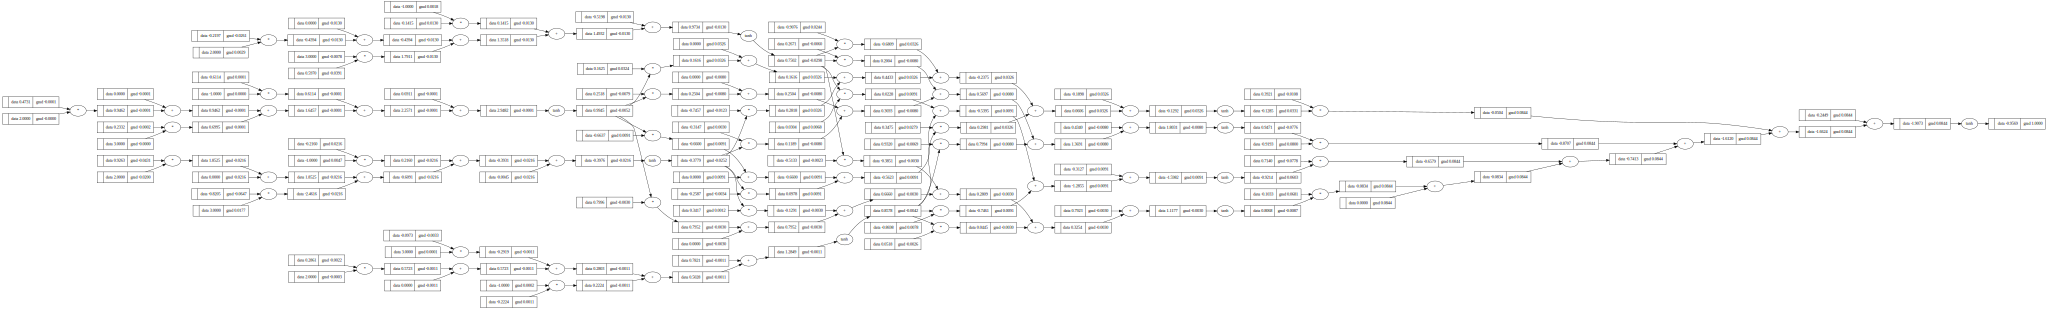

In [ ]:
N.backward()
draw_dot(N)

In [ ]:
n = MLP(3, [4, 4, 1])
# dummy data for a neural net classifier btw: -1 & 1
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
y_pred = [n(x) for x in xs]
y_pred

[Value(data=-0.7332625674758956),
 Value(data=-0.6294793296864577),
 Value(data=-0.8411256181171339),
 Value(data=-0.5284673268710556)]

In [ ]:
loss = sum((y_out-y_gt)**2 for y_gt, y_out in zip(ys, y_pred))
loss

Value(data=5.502938133473743)

In [ ]:
loss.backward()

In [ ]:
print(n.layers[0].neurons[0].w[0])
print(n.layers[0].neurons[0].w[0].grad)

Value(data=0.31026880372161436)
0.0


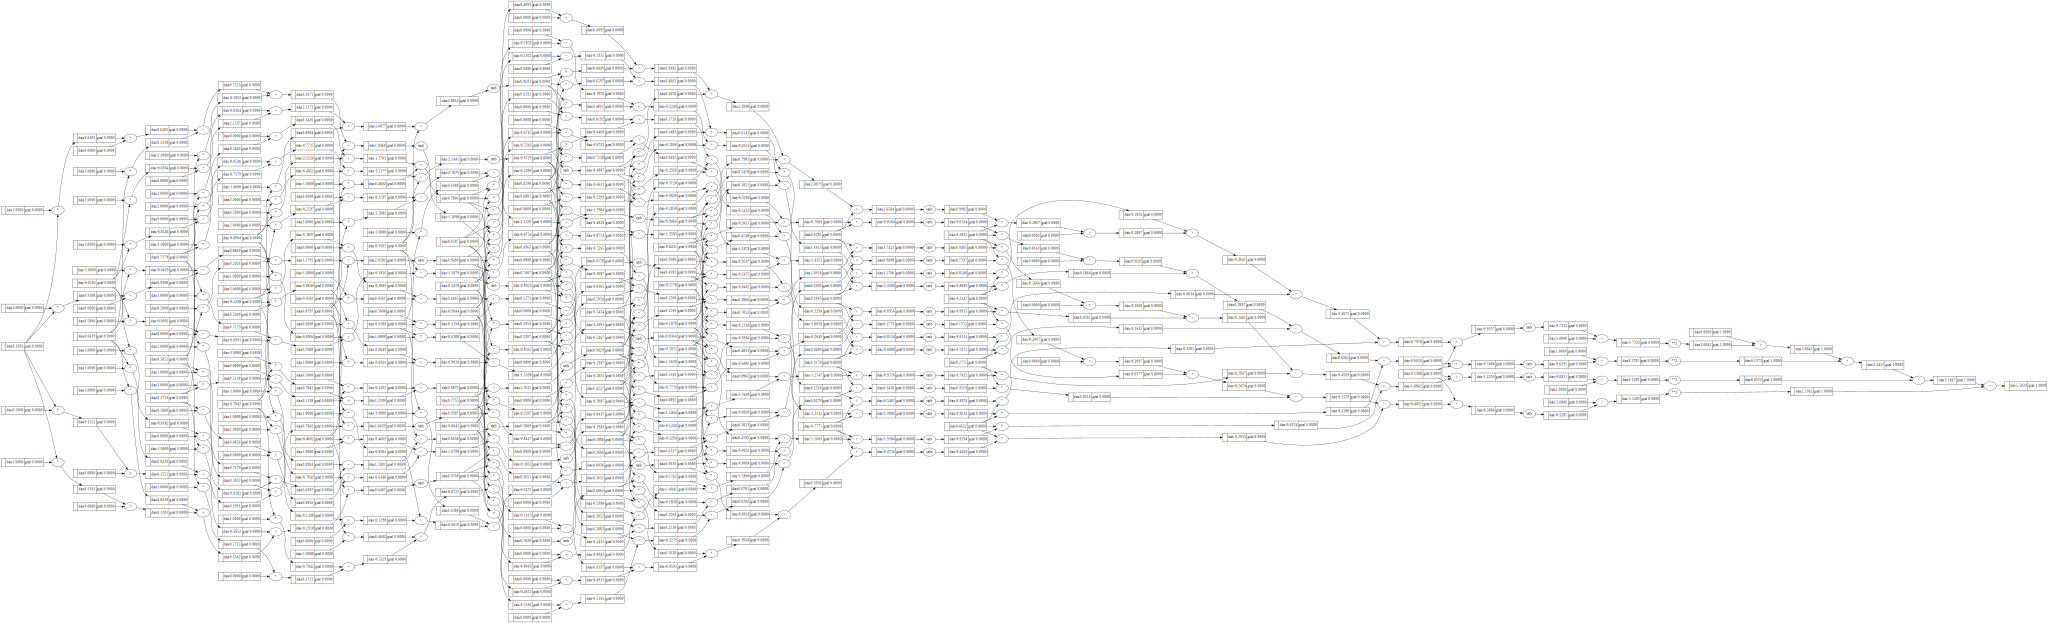

In [ ]:
draw_dot(loss)

#### 4.2 Making our custom classes PyTorch-like

In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
n = MLP(3, [4, 4, 1])
# dummy data for a neural net classifier btw: -1 & 1
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
y_pred = [n(x) for x in xs]
y_pred

[Value(data=0.9060692838920992),
 Value(data=0.8029411560707408),
 Value(data=0.9067566266113745),
 Value(data=0.7091399828567098)]

In [ ]:
loss = sum((y_out-y_gt)**2 for y_gt, y_out in zip(ys, y_pred))
loss

Value(data=6.979740174381226)

In [ ]:
loss.backward()
print(n.layers[0].neurons[0].w[0])
print(n.layers[0].neurons[0].w[0].grad)

Value(data=0.8212423371997535)
0.0


The gradient above and down below are zero for almost all the nodes.

Need to debug!

In [ ]:
#draw_dot(loss)

In [ ]:
n = MLP(3, [4, 4, 1])
# dummy data for a neural net classifier btw: -1 & 1
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
y_pred = [n(x) for x in xs]
y_pred

for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.01 * p.grad

  print(k, loss.data)


0 5.517345003192745
1 5.517345003192745
2 5.517345003192745
3 5.517345003192745
4 5.517345003192745
5 5.517345003192745
6 5.517345003192745
7 5.517345003192745
8 5.517345003192745
9 5.517345003192745
10 5.517345003192745
11 5.517345003192745
12 5.517345003192745
13 5.517345003192745
14 5.517345003192745
15 5.517345003192745
16 5.517345003192745
17 5.517345003192745
18 5.517345003192745
19 5.517345003192745
